In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

2025-03-19 09:42:37.330850: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-19 09:42:37.337835: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-19 09:42:37.389215: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-19 09:42:37.421521: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742377357.454442    3358 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742377357.46

**Load the Dataset**

In [8]:
BASE_DIR = 'Age_Detection/UTKFace/'

In [10]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

FileNotFoundError: [Errno 2] No such file or directory: 'Age_Detection/UTKFace/'

In [12]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()


,image,age,gender


**Exploratory Data Analysis**

In [15]:


from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);



KeyError: 0

<Axes: xlabel='age', ylabel='Density'>

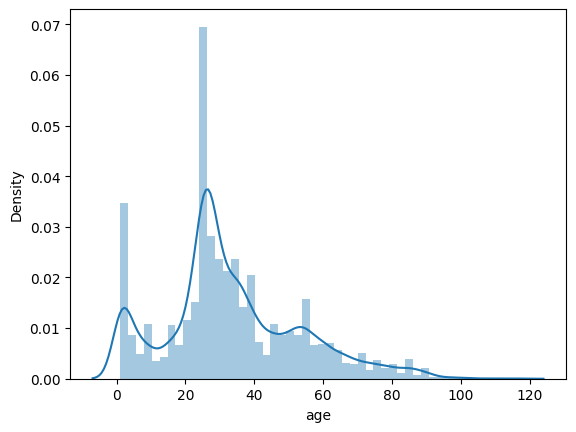

In [65]:
sns.distplot(df['age'])

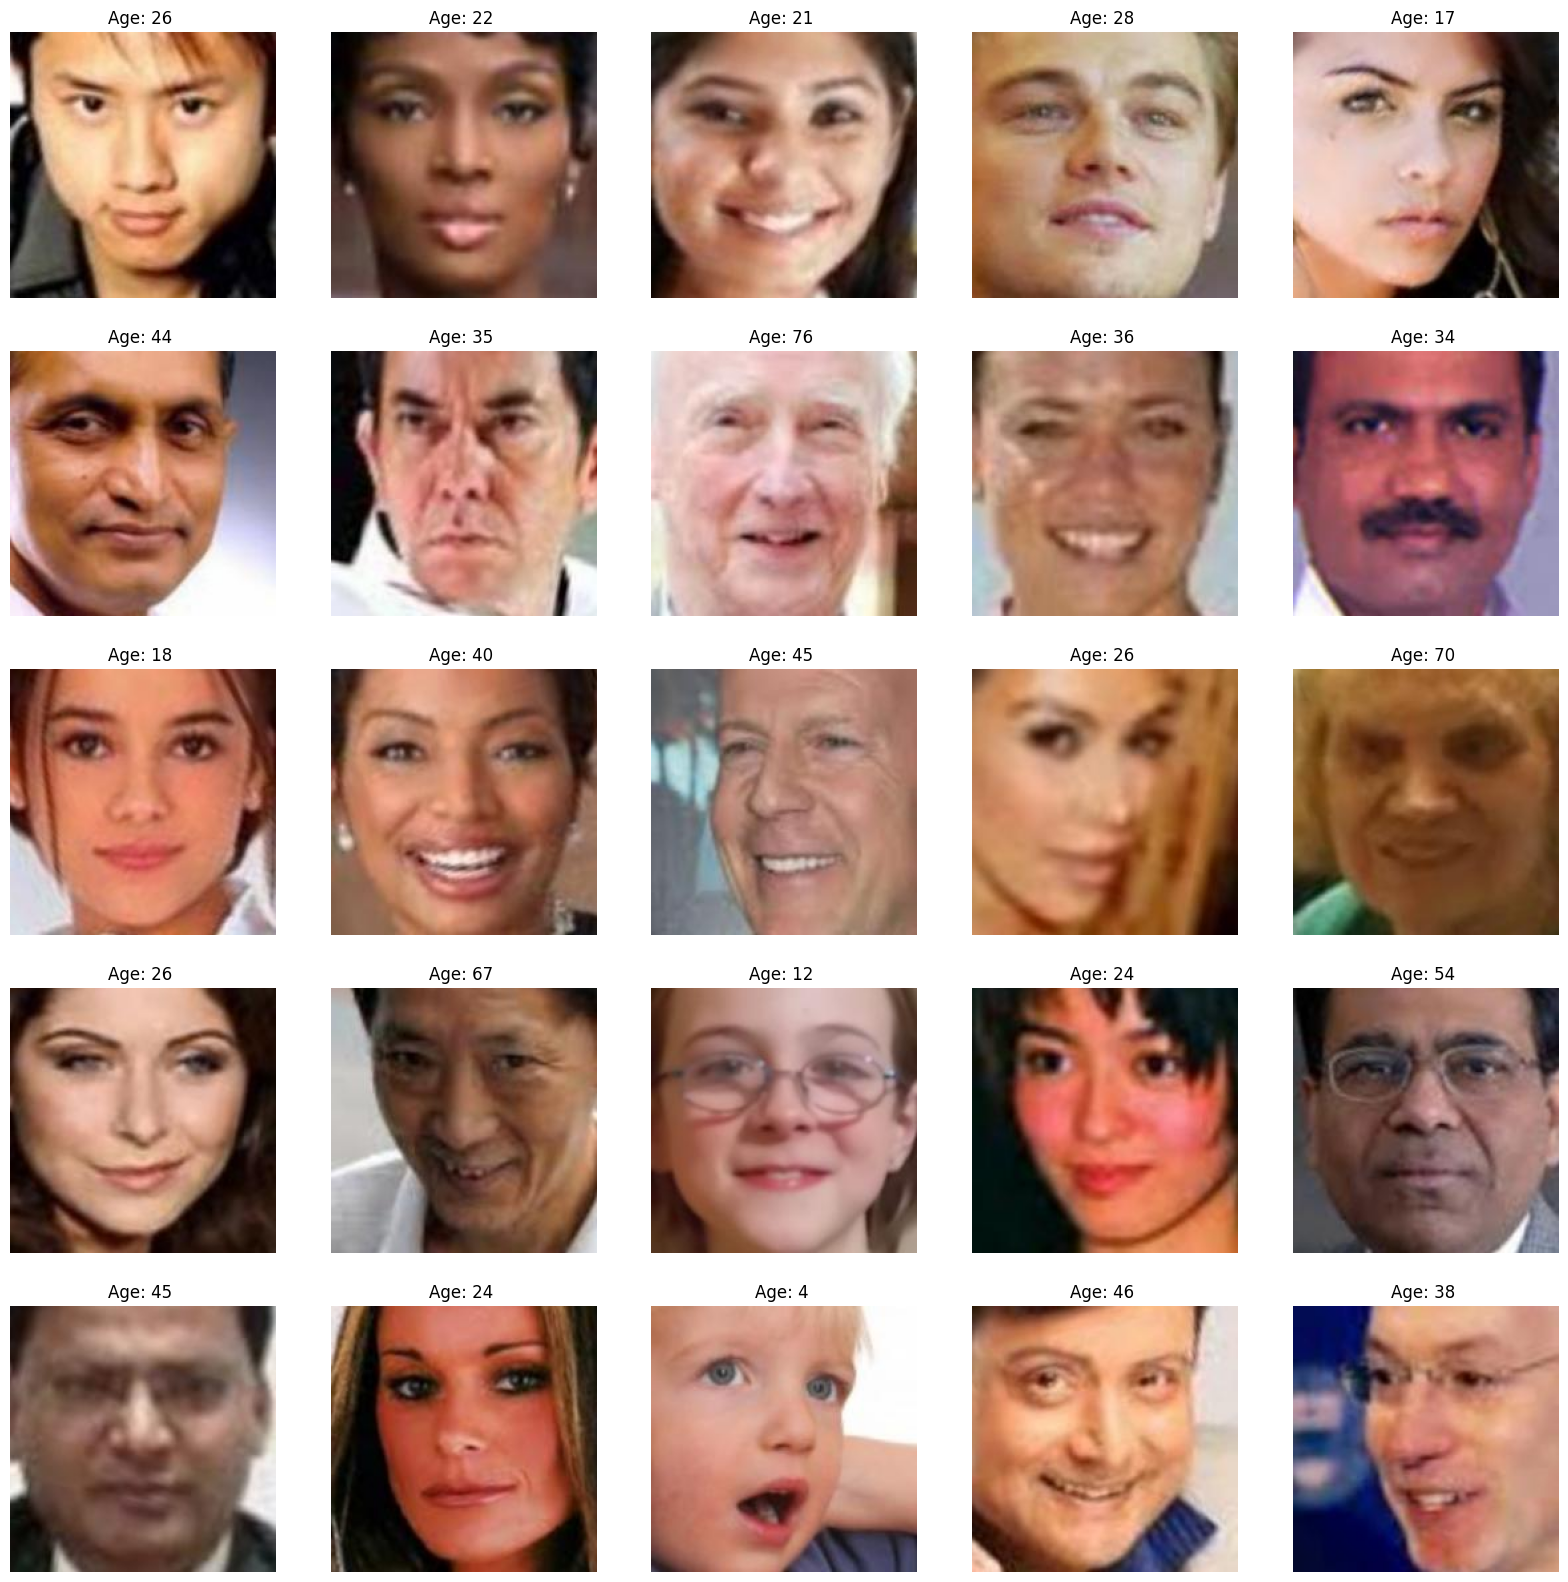

In [68]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age , gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} ")
    plt.axis('off')


**Feature Extraction**

In [69]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.LANCZOS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features


In [70]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [73]:
X.shape

(23708, 128, 128, 1)

In [74]:
# normalize the images
X = X/255.0

In [76]:
y_age = np.array(df['age'])

In [78]:
input_shape = (128, 128, 1)

**Model Creation**

In [88]:


inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_2 = Dropout(0.3) (dense_2)


output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)
model = Model(inputs=[inputs], outputs=[output_2])

model.compile(loss=['mae'], optimizer='adam', metrics=['accuracy'])



In [89]:
print(X.shape, y_age.shape)

(23708, 128, 128, 1) (23708,)


In [103]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'] )

In [104]:
# train model
history = model.fit(x=X, y=[y_age], batch_size=32, epochs=15, validation_split=0.2)

Epoch 1/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.0038 - loss: 40.8169 - val_accuracy: 0.0025 - val_loss: 80.3534
Epoch 2/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.0037 - loss: 36.4476 - val_accuracy: 0.0030 - val_loss: 79.2603
Epoch 3/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.0037 - loss: 33.7401 - val_accuracy: 0.0032 - val_loss: 79.1348
Epoch 4/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.0043 - loss: 30.7511 - val_accuracy: 0.0025 - val_loss: 83.0227
Epoch 5/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.0028 - loss: 30.7342 - val_accuracy: 0.0032 - val_loss: 80.5726
Epoch 6/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.0043 - loss: 29.0303 - val_accuracy: 0.0038 - val_loss: 81.0432
Epoch 7/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.0036 - loss: 29.7232 - val_accuracy: 0.0023 - val_loss: 87.2373
Epoch 8/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.0038 - loss: 27

**Plot the Results**

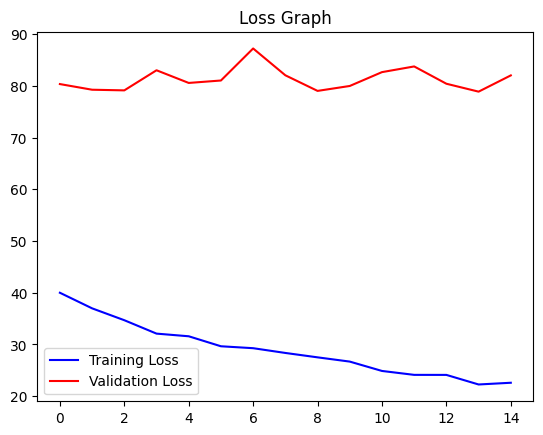

In [106]:
# plot results for age
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()


**Prediction with Test Data**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted Age: 0


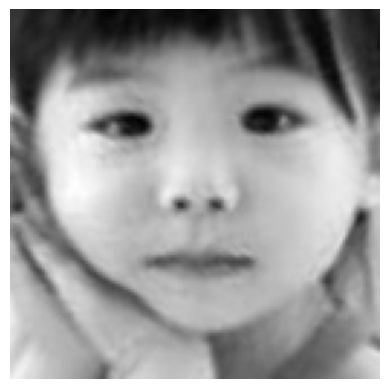

In [118]:
image_index = 100
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_age = round(pred[0][0])
print( "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted Age: 29


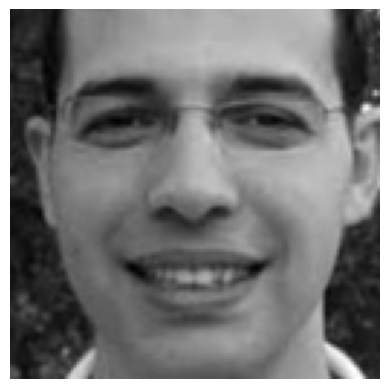

In [117]:
image_index = 3000
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_age = round(pred[0][0])
print( "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Age: 43


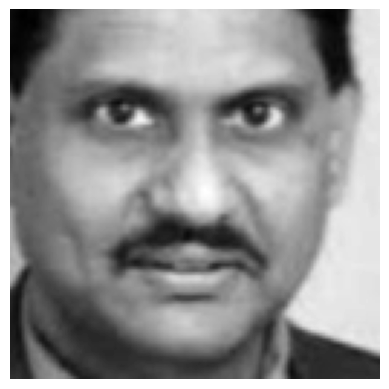

In [116]:
image_index = 1000
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_age = round(pred[0][0])
print( "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');